In [1]:
#@title Initialize environment

#@markdown We recommend setting up a working directory on your google drive. This is a 
#@markdown convenient way to pass files in and out of this analysis. It will 
#@markdown also allow you to save your work. If you put `biophysics` into the form
#@markdown field below, the analyis will save all of its calculations in the 
#@markdown `biophysics` directory in MyDrive (i.e. the top directory at
#@markdown https://drive.google.com). This script will create the directory if 
#@markdown it does not already exist. If the directory already exists, any files
#@markdown that are already in that directory will be available for the analysis. 
#@markdown You could, for example, put a file called `data.csv` in `biophysics` and then
#@markdown access it as "data.csv" in all cells below.
#@markdown <br/>
#@markdown Note: Google may prompt you for permission to access the drive. 
#@markdown To work in a temporary colab environment, leave this blank. Your results
#@markdown will disappear when you close the directory. 

try:
    import google.colab
    RUNNING_IN_COLAB = True
except ImportError:
    RUNNING_IN_COLAB = False
except Exception as e: 
    err = "Could not figure out if runnning in a colab notebook\n"
    raise Exception(err) from e

# ------------------------------------------------------------------------------
# Imports

if RUNNING_IN_COLAB:
    %pip install -q ipywidgets

%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

import os

# ------------------------------------------------------------------------------
# Environment

if RUNNING_IN_COLAB:
    
    working_dir = "/content/"

    # Select a working directory on google drive
    google_drive_directory = "loving_it" #@param {type:"string"}
    google_drive_directory = google_drive_directory.strip()

    # Set up google drive
    if google_drive_directory != "":

        from google.colab import drive
        drive.mount('/content/gdrive/')

        working_dir = f"/content/gdrive/MyDrive/{google_drive_directory}"
        os.system(f"mkdir -p {working_dir}")

    os.chdir(working_dir)
    print(f"Working directory: {os.getcwd()}/")

    print("\nCurrent directory contents:")
    print(os.getcwd())
    for f in os.listdir("."):
        print(f"    {f}")
    print()
    

# ------------------------------------------------------------------------------
# Default graph label sizing

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# ------------------------------------------------------------------------------
# Data locations


if RUNNING_IN_COLAB:
    DATASET_MAPPER = {"E. coli":"https://github.com/harmsm/biochem-jupyter-notebooks/raw/master/dsc/ec.csv",
                      "T. thermophilus":"https://github.com/harmsm/biochem-jupyter-notebooks/raw/master/dsc/tt.csv"}
else:
    DATASET_MAPPER = {"E. coli":"dsc/ec.csv",
                      "T. thermophilus":"dsc/tt.csv"}
    
# ------------------------------------------------------------------------------
# Thermodynamic functions
    
def dH_v_T(T,dCp,dH,Tm):
    
    return dCp*(T - Tm) + dH

def dS_v_T(T,dCp,dH,Tm):
    
    return dCp*np.log(T/Tm) + dH/Tm

def dG_v_T(T,dCp,dH,Tm):

    return dH_v_T(T,dCp,dH,Tm) - T*dS_v_T(T,dCp,dH,Tm)

def K_v_T(T,dCp,dH,Tm,R=0.008314):
    
    return np.exp(-dG_v_T(T,dCp,dH,Tm)/(R*T))

def Cp_v_T(T,dCp,dH,Tm,B0=0,B1=0,R=0.008314):
    
    KT = K_v_T(T,dCp,dH,Tm)
    HT = dH_v_T(T,dCp,dH,Tm)
    
    a = KT*dCp/(1 + KT)
    b = KT*(HT**2)/((1 + KT)**2 * R * (T**2))
    
    return B0 + B1*T + a + b

def fx_v_T(T,dCp,dH,Tm,R=0.008314):
    
    dG = dG_v_T(T,dCp,dH,Tm)
    
    weight = np.exp(-dG/(R*T))
    
    return 1/(1 + weight)

# ------------------------------------------------------------------------------
# Plotting functions

def plot_raw_data(df):

    fig, ax = plt.subplots(1,figsize=(6,6))
    ax.set_xlabel("temperature (K)")
    ax.set_ylabel("heat capacity (kJ/mol/K)")
    ax.plot(df.temperature,df.buffer,label="buffer",lw=2)
    ax.plot(df.temperature,df.protein,label="protein",lw=2)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(f"Unfolding of {dataset} RNaseH")

    ax.legend()
    fig.tight_layout()
    plt.show()

def plot_and_integrate(df,left_edge,right_edge,Tm):
    
    if left_edge >= Tm:
        err = "left_edge must be less than Tm\n"
        raise ValueError(err)

    if right_edge <= Tm:
        err = "right_edge must be greater than Tm\n"
        raise ValueError(err)
    
    df = df.copy()

    # Blank the data
    df["blanked"] = df.protein - df.buffer

    # Construct a plot
    fig, ax = plt.subplots(1,figsize=(6,6))
    ax.set_xlabel("temperature (K)")
    ax.set_ylabel("heat capacity (kJ/mol/K)")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Plot main series
    ax.plot(df.temperature,
            df.blanked,
            "-",color="black",lw=3)

    # Get some convenient points for plotting and operations
    min_T = np.min(df.temperature)
    max_T = np.max(df.temperature)
    max_value = np.max(df.blanked)*1.05
    
    to_integrate = df.loc[np.logical_and(df.temperature >= left_edge,
                                         df.temperature <= right_edge),:]
    # Draw integrated curve
    ax.fill(to_integrate.temperature,to_integrate.blanked,color="gray")

    # Get the left and right edge indexes
    left_edge_idx = df.index[df.temperature == left_edge][0]
    right_edge_idx = df.index[df.temperature == right_edge][0]

    # Get line drawing baseline
    p_min = df.loc[left_edge_idx,"blanked"]
    p_max = df.loc[left_edge_idx,"blanked"]
    baseline_m = (p_max - p_min)/(right_edge - left_edge)
    baseline_b = p_min - baseline_m*left_edge

    # Integrate (Riemann)
    dT = df.loc[left_edge_idx+1,"temperature"] - df.loc[left_edge_idx,"temperature"]
    dH = to_integrate.blanked - (baseline_m*to_integrate.temperature + baseline_b)
    dH = np.sum(dH)*dT

    # Plot the Tm line
    ax.plot((Tm,Tm),(0,max_value),"--",color="black",lw=3)
    ax.text(Tm,max_value*1.05,f"Tm",horizontalalignment="center")
    
    # Plot the left and right edge lines
    ax.plot((left_edge,left_edge),(0,np.max(to_integrate.blanked)*1.05),"-",color="black",lw=1)
    ax.plot((right_edge,right_edge),(0,np.max(to_integrate.blanked)*1.05),"-",color="black",lw=1)

    # Get dCp
    Cp_fold = np.mean(df.loc[df.index[0]:left_edge_idx,"blanked"])
    Cp_unfold = np.mean(df.loc[right_edge_idx:df.index[-1],"blanked"])
    dCp = Cp_unfold - Cp_fold
    
    # Get Cp lines
    ax.plot((min_T,max_T),(Cp_fold,Cp_fold),'-',color='red')
    ax.plot((min_T,max_T),(Cp_unfold,Cp_unfold),'-',color='red')

    # Get info to draw dCp arrows
    T_to_draw = right_edge + (max_T - right_edge)/2
    total_T_diff = max_T - min_T

    # Draw dCp information
    ax.arrow(T_to_draw,Cp_fold,dx=0,dy=Cp_unfold-Cp_fold,color="red",width=0.5,length_includes_head=True)
    ax.arrow(T_to_draw,Cp_unfold,dx=0,dy=Cp_fold-Cp_unfold,color="red",width=0.5,length_includes_head=True)
    ax.text(T_to_draw + total_T_diff*0.02,
            Cp_fold + dCp/2,
            f"$\Delta C_p$",color='red',
            verticalalignment="center",
            horizontalalignment="left")
    
    
    dS = dH/Tm

    ax.text(min_T,max_value*0.950,f"$T_m$: {Tm:.1f} K")
    ax.text(min_T,max_value*0.875,f"$\Delta C_p$: {dCp:.1f} kJ/mol/K")
    ax.text(min_T,max_value*0.800,f"$\Delta H$: {dH:.1f} kJ/mol")
    ax.text(min_T,max_value*0.725,f"$\Delta S$: {dS:.1f} kJ/mol")

    fig.tight_layout()

    plt.show()

def plot_dG_v_T(dCp,dH,Tm):
    
    T = np.arange(200,400.5,0.5)

    fig, ax = plt.subplots(1,figsize=(6,8))
    ax.plot(T,dG_v_T(T,dCp=dCp,dH=dH,Tm=Tm),lw=3,label="$\Delta G$")
    ax.plot(T,dH_v_T(T,dCp=dCp,dH=dH,Tm=Tm),lw=3,label="$\Delta H$")
    ax.plot(T,-T*dS_v_T(T,dCp=dCp,dH=dH,Tm=Tm),lw=3,label="$-T\Delta S$")

    
    ax.plot((T[0],T[-1]),[0,0],'--',color='black')
    ax.set_xlabel("temperature (K)")
    ax.set_ylabel("$\Delta G_{unfold}$ (kJ/mol)")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim(np.min(T),np.max(T))
    ax.set_ylim(-500,500)
    ax.legend()
    
    plt.show()
    

def plot_fx_folded(dCp,dH,Tm):

    fig, ax = plt.subplots(1,figsize=(6,6))
    T = np.arange(200,400.5,0.5)
    ax.plot(T,fx_v_T(T,dCp=dCp,dH=dH,Tm=Tm),"-",lw=2)
    
    ax.set_xlabel("temperature (K)")
    ax.set_ylabel("fraction of molecules folded")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim(np.min(T),np.max(T))
    ax.set_ylim(0,1)
    
    ax.set_title("fraction of proteins folded")
    
    fig.tight_layout()
    
    plt.show()

## Background 

We are interested in extracting information about the thermodynamics of protein folding using differential scanning calorimetry (DSC). In a DSC experiment, we apply current to heat up a cell containing either buffer or protein. The instrument measures the temperature while keeping track of the amount of energy added. In doing so, it measures the heat capacity ($C_{p}$), which is defined as: 

$$C_{p} = \frac{\delta q}{dT}$$ 

where $\delta q$ is infinitesimal heat and $dT$ is the change in temperature. Assuming the protein unfolds below the maximum temperature of the experiment, we will observe a phase transition over which the protein goes from being folded to unfolded. 

We can use DSC to extract the contributions of enthalpy and entropy to the protein folding reaction as a function of temperature. This relies on the following thermodynamic relationships. 

$$\Delta G(T)=\Delta H(T)-T\Delta S(T)$$

$$\Delta H(T)=\Delta C_{p}\left(T-T_{m}\right)+\Delta H_{Tm}$$

$$\Delta S(T)=\Delta C_{p}ln\left(\frac{T}{T_{Tm}}\right)+\Delta S_{Tm}$$

All of this information is present in a DSC unfolding trace. 

+ $\Delta C_{p}$ is the difference in the folded and unfolded baselines
+ $T_{m}$ is the midpoint of the unfolding curve.
+ $\Delta H_{T_{m}}$ is the area of the peak. 
+ $\Delta S_{Tm}$ is $\Delta H_{Tm}/T_{m}$


### Enthalpy
How do we know that $\Delta H_{T_{m}}$ is the area of the peak? We can start by noting:

$$\delta q=C_{p}dT$$

We also know that:

$$dH=\delta q+dw$$

Since the system is not doing work, we get:

$$dH=\delta q$$

We can combine with our expression for $\delta q$ above:

$$dH=C_{p}dT$$

Finally, we can integrate:

$$\int dH=\Delta H=\int C_{p}dT$$

We have no idea (at this point) what the functional form of $C_{p}(T)$ is, but it doesn't matter. In a DSC experiment, we experimentally measure $C_{p}(T)$ and can thus integrate numerically. 

### Entropy
At the $T_{m}$ we have half folded, half unfolded. This means:

$$\Delta G(T_{m})=0$$

This means that: 

$$\Delta G(T)=0=\Delta H(T_{m})-T_{m}\Delta S(T_{m})$$

Rearrange, yielding:

$$\Delta S(T_{m})=\Delta H(T_{m})/T_{m}$$


### Data 

The data included in this exercise are derived from thermodynamic parameters for the unfolding of the enzyme RNAaseH reported by: 

Hart KM, Harms MJ, Schmidt BH, Elya C, Thornton JW, Marqusee S “Thermodynamic System Drift in Protein Evolution.” (2014) *PLOS Biology*. https://doi.org/10.1371/journal.pbio.1001994


### Real considerations
In the exercise below, we will "manually" integrate the curves and identify $T_{m}$. When experimentalists analyze DSC curves, they usually do so by fitting a statistical model to their data rather than integrating directly. One such model is:

$$C_{p}(T)=B_{0}+B_{1}T+\Big[\frac{K(T)\Delta C_{p}}{1+K(T)}+\frac{K(T)\Delta H(T)^{2}}{(1+K(T))^{2}RT^{2}}\Big]$$

In this model:
+ $B_{0}$ and $B_{1}$ are the intercept and slope of $C_{p,folded}$ (the folded baseline). 
+ $K(T)=exp(-\Delta G(T)/RT)$, where $\Delta G(T) =  \Delta C_{p}\left(T-T_{m}\right)+\Delta H_{Tm} - TC_{p}ln\left(\frac{T}{T_{Tm}}\right)+\Delta S_{Tm}$.
+ $\Delta H(T) = \Delta C_{p}\left(T-T_{m}\right)+\Delta H_{Tm}$.

If you really want to be a nerd, you can use nonlienar regression to fit this model to the data and extract the relevant parameters. 



## Plot experimental data for unfolding of RNaseH

The files "ec.csv" and "tt.csv" contain experimental DSC data for the unfolding of the protein RNase H taken from either *E. coli* (ec) or *T. thermophilus*. There are three columns in each file:

+ The "temperature" column holds the temperature of the calorimeter cell in Kelvin. 

+ The "buffer" column holds the measured $C_{p}$ as a function of temperature for buffer alone (20 mM NaOAc, 50 mM KCl, and 1 mM TCEP, pH 5.5). 

+ The "protein" column holds the measured $C_{p}$ as a function of temperature for the $50\ \mu g/mL$  protein dissolved in the buffer. 


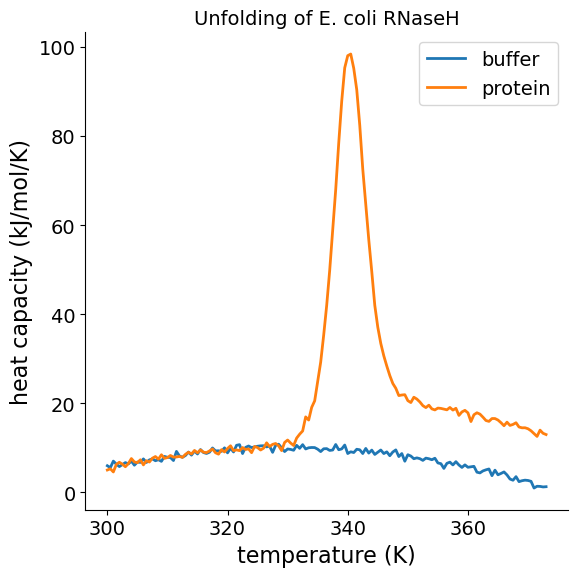

,temperature,buffer,protein
0,300.0,5.995728,5.036876
1,300.5,5.572730,5.306021
2,301.0,7.032090,4.601096
3,301.5,6.346354,6.311202
4,302.0,5.808100,6.778187
...,...,...,...
142,371.0,0.994526,13.217556
143,371.5,1.387035,12.577425
144,372.0,1.359231,13.982262
145,372.5,1.237980,13.274784


In [2]:
#@title Raw experimental output from a DSC experiment

# dataset should be "E. coli" or "T. thermophilus"
dataset = "E. coli" #@param ["E. coli","T. thermophilus"]
df = pd.read_csv(DATASET_MAPPER[dataset])

plot_raw_data(df)
    
df

### <font color='#9D33FF' size="+2">Explain</font>

<font size="+1">How is heat capacity ($C_{p}$) measured? Where does it come from molecularly?</font>

---
### <font color='#9D33FF' size="+2">Explain</font>

<font size="+1">Start with the *E. coli* dataset. Why does the graph have the features it does? What is happening molecularly before the peak? At the peak? After the peak?</font>

---

### <font color='#9D33FF' size="+2">Explain</font>

<font size="+1">Which protein is more robust to temperature, *E. coli* RNaseH or *T. thermophilus* RNaseH? How do you know?</font>

---

In [3]:
## Fit experimental results
#@title Fit experimental results

dataset = "E. coli" #@param ["E. coli","T. thermophilus"]
df = pd.read_csv(DATASET_MAPPER[dataset])

max_T = np.max(df.temperature)
min_T = np.min(df.temperature)
Tm_value = np.round(min_T + (max_T - min_T)/2,0)
left_edge = np.round(min_T + (Tm_value - min_T)/2,0)
right_edge = np.round(Tm_value + (max_T - Tm_value)/2,0)

Tm_slider = widgets.FloatSlider(min=min_T,max=max_T,step=0.5,
                                value=Tm_value,description="Tm")
left_slider = widgets.FloatSlider(min=min_T,max=max_T,step=0.5,
                                  value=left_edge,description="left edge")
right_slider = widgets.FloatSlider(min=min_T,max=max_T,step=0.5,
                                   value=right_edge,description="right edge")

w = widgets.interactive(plot_and_integrate,
                        df=fixed(df),
                        Tm=Tm_slider,
                        left_edge=left_slider,
                        right_edge=right_slider)
                        
display(w)

interactive(children=(FloatSlider(value=318.0, description='left edge', max=373.0, min=300.0, step=0.5), Float…

In [4]:
## Plot dG versus T
#@title Plot dG versus T

style = {'description_width': 'initial'}
Tm_slider = widgets.FloatSlider(min=270,max=400,step=1,
                                value=340,description="Tm",style=style)
dCp_slider = widgets.FloatSlider(min=-15,max=15,step=0.5,
                                 value=12,description="dCp",style=style)
dH_slider = widgets.FloatSlider(min=-1000,max=1000,step=50,
                                value=650,description="dH @ Tm",style=style)

w = widgets.interactive(plot_dG_v_T,
                        dCp=dCp_slider,
                        dH=dH_slider,
                        Tm=Tm_slider)
display(w)
    
    

interactive(children=(FloatSlider(value=12.0, description='dCp', max=15.0, min=-15.0, step=0.5, style=SliderSt…

---

### <font color='#9D33FF' size="+2">Explain</font>

<font size="+1">Can you justify the shape of the $\Delta G(T)$ curve using the shapes of the $\Delta H(T)$ and $-T\Delta S(T)$ curves? It might help to consider two points on the curves: What is happening at low temperature? At high temperature?</font>

---

### <font color='#9D33FF' size="+2">Explain</font>

<font size="+1">What are the (approximate) $\Delta G$ values for *E. coli* or *T. thermophilus* RNaseH at $300\ K$? What contributes the most to the increased stability of *T. thermophilus*, $\Delta H$ or $\Delta C_{p}$? What, mechanistically, might explain how *T. thermophilus* stabilized its enzyme?</font>

---

The data below are the measured entropic and enthalpic contributions to transfer a mole of benzene atoms from a benzene solution into water (Dill 1990 *Biochemistry* 29(31):7141). These data, in conjunction with DSC data, were interpreted as evidence that the hydrophobic effect was important for protein folding. 

![img](https://github.com/harmsm/biochem-jupyter-notebooks/raw/master/dsc/dill-benzene-transfer.png)


### <font color='#9D33FF' size="+2">Explain</font>

<font size="+1">What argument might link this benzene transfer data to the hydrophobic effect in protein folding?</font>

---

In [5]:
## Plot dG versus T
#@title Plot dG versus T

style = {'description_width': 'initial'}
Tm_slider = widgets.FloatSlider(min=270,max=400,step=1,
                                value=340,description="Tm",style=style)
dCp_slider = widgets.FloatSlider(min=-15,max=15,step=0.5,
                                 value=12,description="dCp",style=style)
dH_slider = widgets.FloatSlider(min=-1000,max=1000,step=50,
                                value=650,description="dH @ Tm",style=style)

w = widgets.interactive(plot_fx_folded,
                        dCp=dCp_slider,
                        dH=dH_slider,
                        Tm=Tm_slider)
display(w)


        

interactive(children=(FloatSlider(value=12.0, description='dCp', max=15.0, min=-15.0, step=0.5, style=SliderSt…

---

### <font color='#9D33FF' size="+2">Explain</font>

<font size="+1">Does this curve make sense to you? Anything surprising? What do you think is going on?</font>